In [1]:
import functions0 as f0
import numpy as np
import datetime
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

## IBM open-science-prize-2021/22 solution. By Quantum Polo Gang: Ruben, Fabio & Valerio

## Decomposition:
- We computed numerically the operator of N trotter steps, for a certain evolution time: $U^n$
- Observing that this operator preserves the magnetization of the system, if the initial state belongs to an eigenspace of the magnetization is possible to decompose the operator with 4 c-not. If the initial state is a superposition of states with different magnetization the best decomposition we found has 11 c-not (14 for the Jakarta geometry).
- Our initial state is $|110>$ (qubits 5,3 and 1 respectively) so we can use the best decomposition (4 c-not).

To see the decomposition procedure open  *decomposition.ipynb* file.

Let's start from the defining of the evolution circuit parameters:

- *steps*: number of trotter steps (integer).
- *time*: time of evolution (double).
- *initial_state*: the 3-qubit initial state (string): from right to left, associated with qubits 1, 3 and 5 respectively
- *reps*: number of times each circuit is runned, in order to compute a standard deviation of the fidelity.
- *shots*: number of shots for every run.
- *backend*: here you can choose on which backend run the simulation: *backend_sim_jakarta* (noisy simulator), *backend_real_jakarta* (real device), *backend_sim* (simulator)

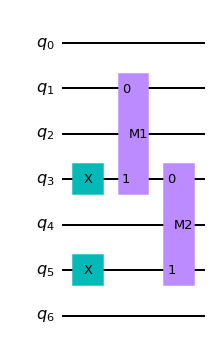

In [2]:
steps=42   
time=np.pi
initial_state="110"
reps = 2
shots = 32000
backend = backend_sim_jakarta

qr, qc = f0.evolution_cirquit(steps=steps, time=time, initial_state="110") #DEVO IMPLEMENTARLA PER QUALSIASI STATO INIZIALE!
qc.draw(output="mpl")

Then we add the copy check for the mitigation (see *Ancillas_Error_mitigation_Git_Hub.pynb*)

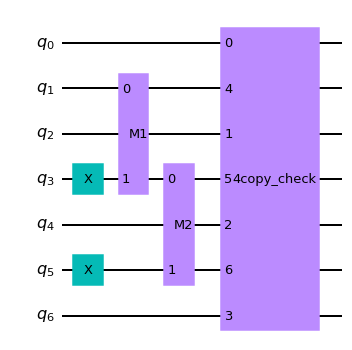

In [3]:
qc = f0.add_check(qc, [qr[1],qr[3],qr[5]], [qr[0],qr[2],qr[4],qr[6]], type="4copy_check")
qc.draw(output="mpl")

Then, we build the tomography circuits

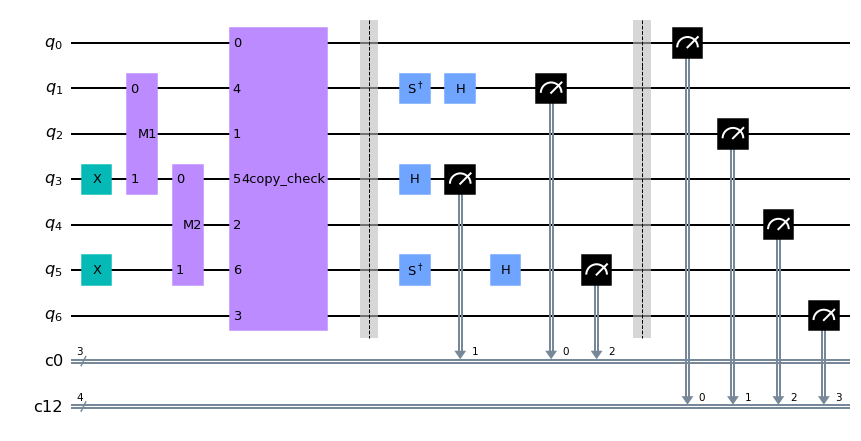

In [4]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

qcs = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]])
qcs_na = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]])

## add the measure on the ancillas

for qc in qcs:
    cr_anc = ClassicalRegister(4)
    qc.add_register(cr_anc)
    qc.barrier()
    qc.measure([0,2,4,6],cr_anc)

## qcs_tot is a list holding the tomography cirquits reps times.

qcs_tot = []
for _ in range(reps):
    qcs_tot=qcs_tot + qcs

qcs[10].draw(output="mpl")

Building the calibration circuits

In [5]:
qcs_calibs, meas_calibs = f0.calibration_cirquits("column_evolution_remake", q_anc=[0,2,4,6], check="yes", check_type="4copy_check")
state_lables = f0.bin_list(7)

In [12]:
qcs_calibs[0].draw()

░ ┌──────────────┐ ░ ┌─┐                  
 q4_0: ──────────────────░─┤0             ├─░─┤M├──────────────────
       ┌───────────────┐ ░ │              │ ░ └╥┘         ┌─┐      
 q4_1: ┤0              ├─░─┤4             ├─░──╫──────────┤M├──────
       │               │ ░ │              │ ░  ║ ┌─┐      └╥┘      
 q4_2: ┤               ├─░─┤1             ├─░──╫─┤M├───────╫───────
       │               │ ░ │              │ ░  ║ └╥┘       ║ ┌─┐   
 q4_3: ┤1 circuit-1298 ├─░─┤5 4copy_check ├─░──╫──╫────────╫─┤M├───
       │               │ ░ │              │ ░  ║  ║ ┌─┐    ║ └╥┘   
 q4_4: ┤               ├─░─┤2             ├─░──╫──╫─┤M├────╫──╫────
       │               │ ░ │              │ ░  ║  ║ └╥┘    ║  ║ ┌─┐
 q4_5: ┤2              ├─░─┤6             ├─░──╫──╫──╫─────╫──╫─┤M├
       └───────────────┘ ░ │              │ ░  ║  ║  ║ ┌─┐ ║  ║ └╥┘
 q4_6: ──────────────────░─┤3             ├─░──╫──╫──╫─┤M├─╫──╫──╫─
                         ░ └──────────────┘ ░  ║  ║  ║ └╥┘ ║  ║  ║ 
c29: 7/════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩═
                                               0  1  2  3  4  5  6

Than we run all the circuits

In [6]:
jobs_evo=execute(qcs_tot, backend=backend, shots=shots)
job_cal_our=execute(qcs_calibs, backend=backend, shots=shots)

In [7]:
jobs_evo_result = f0.jobs_result(job_evolution = jobs_evo, reps = reps)

or we can retrieve the jobs

In [8]:
#evo_ID = "6233ae39d97bff04d66929e9"
#cal_ID = "6233ae3ba2f72dff43da994f"

#evo_job=backend.retrieve_job(evo_ID)
#job_cal_our=backend.retrieve_job(cal_ID)

Next we apply the mitigation in the following way:

- measure mitigation: we apply the inverse of the calibration matrix to each circuit (see *measure_mitigation.ipynb*)
- ancillas mitigation: we throw away all the measures which contain a value for the ancillas physically forbidden.

this is done by the *mitigate* function.

Then we compute the fidelity for both the mitigated results and not-mitigated ones, in order check the gain given by the mitigation.

In [9]:
meas_fitter_our = mc.CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)

target_state = (One^One^Zero).to_matrix()

fids=np.zeros([reps,3])
fids_mean=np.zeros(3)
fids_dev=np.zeros(3)

for j in range(reps):
    
    res = jobs_evo_result[j]

    new_res_our, new_res_nm = f0.mitigate(res, Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_our)
    new_res_not_mitigated = f0.mitigate(res, Measure_Mitig="no", ancillas_conditions=f0.bin_list(4))

    fids[j,0] = f0.fidelity_count(new_res_not_mitigated, qcs_na, target_state)
    fids[j,1] = f0.fidelity_count(new_res_nm, qcs_na, target_state)
    fids[j,2] = f0.fidelity_count(new_res_our, qcs_na, target_state)

for i in range(3):
    fids_mean[i]=np.mean(fids[:,i])
    fids_dev[i]=np.std(fids[:,i])


Printing the fidelity

In [10]:
labels = ["raw:                               ", "ancillas mitigation:               ", "ancillas and measurment mitigation:"]

for i in range(3):            
    print(labels[i], fids_mean[i], " +- ", fids_dev[i])

raw:                                0.6586758194970523  +-  0.0008389411320021134
ancillas mitigation:                0.704751162524065  +-  0.0008509752494144096
ancillas and measurment mitigation: 0.831407942704721  +-  0.0006235780594295859


In [11]:
fids

array([[0.65783688, 0.70390019, 0.83078436],
       [0.65951476, 0.70560214, 0.83203152]])